In [1]:
import xarray as xr
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
import glob
import os
import pandas as pd

obs_ssdflux_path="/Volumes/Thalassa/ERA5_data/SSDflux_rg/"
obs_curl_path="/Volumes/Thalassa/ORAS5/ORAS5_wind_stress_curl_rg/"
obs_wsm_path="/Volumes/Thalassa/ORAS5/ORAS5_wind_stress_magnitude_rg/"
obs_shdr_path="/Volumes/Thalassa/CORA_SHDR_rg/"

obs_shdr=xr.open_mfdataset(sorted(glob.glob(obs_shdr_path+'*.nc')))
obs_curl=xr.open_mfdataset(sorted(glob.glob(obs_curl_path+'*.nc')))
obs_wsm=xr.open_mfdataset(sorted(glob.glob(obs_wsm_path+'*.nc')))
obs_ssdflux=xr.open_dataset(obs_ssdflux_path+'SSDflux_ERA5_ORAS5.nc')


# --- Compute Climatology (Monthly Means) ---
obs_shdr_clim = obs_shdr.groupby('time.month').mean(dim='time')
obs_curl_clim = obs_curl.groupby('time_counter.month').mean(dim='time_counter')
obs_ssdflux_clim = obs_ssdflux.groupby('time.month').mean(dim='time')
obs_wsm_clim = obs_wsm.groupby('time_counter.month').mean(dim='time_counter')


In [2]:
cmip6_shdr_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/shdr.nc")
cmip6_curl_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/curl.nc")
cmip6_ssdflux_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/ssdflux.nc")
cmip6_wsm_ens_all=xr.open_dataset("/Volumes/Thalassa/cmip6_clim_ens/wsm.nc")

In [153]:
season=[1,2,3,4,5,6,7,8,9,10,11,12]
diff_wsm=cmip6_wsm_ens_all.wsm.median('model').sel(month=season).mean('month')-obs_wsm_clim.wsm.sel(month=season).mean('month')
#diff.plot(vmin=-0.04,vmax=0.04)

diff_curl=cmip6_curl_ens_all.curl.median('model').sel(month=season).mean('month')-obs_curl_clim.curl.sel(month=season).mean('month')
#diff.plot(vmin=-0.1e-8,vmax=0.1e-8)

diff_Fs=cmip6_ssdflux_ens_all.Fs.median('model').sel(month=season).mean('month')-obs_ssdflux_clim.Fs.sel(month=season).mean('month')
#diff.plot(vmin=-0.01e-5,vmax=0.01e-5)

diff_Ft=(cmip6_ssdflux_ens_all.Ft.median('model').sel(month=season).mean('month')-obs_ssdflux_clim.Ft.sel(month=season).mean('month'))
#diff.plot(vmin=-0.1e-5,vmax=0.1e-5)

zonal_bias_wsm = diff_wsm.mean(dim='lon')
zonal_bias_curl = diff_curl.mean(dim='lon')
zonal_bias_Fs = diff_Fs.mean(dim='lon')
zonal_bias_Ft = diff_Ft.mean(dim='lon')




lon=diff_Ft.lon
lat=diff_Ft.lat

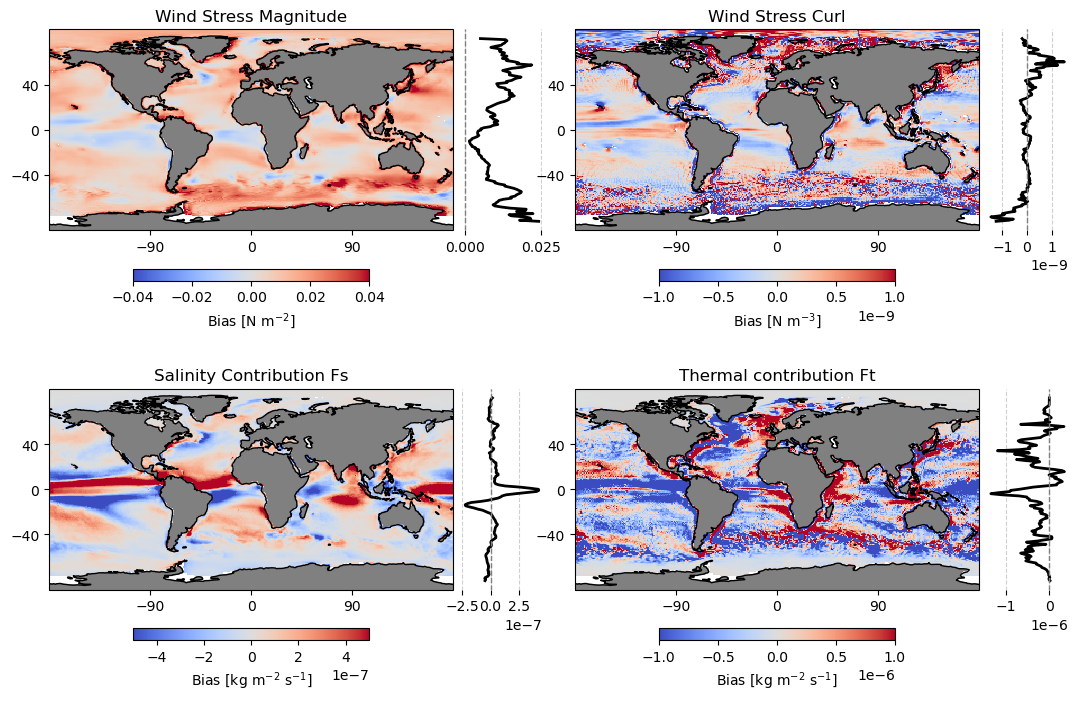

In [157]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
from matplotlib.gridspec import GridSpec
from cartopy.util import add_cyclic_point


fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.4)
projection = ccrs.PlateCarree(central_longitude=0)

titles = ["Wind Stress Magnitude", "Wind Stress Curl", "Salinity Contribution Fs", "Thermal contribution Ft"]
units = ["[N m$^{-2}$]", "[N m$^{-3}$]", "[kg m$^{-2}$ s$^{-1}$]", "[kg m$^{-2}$ s$^{-1}$]"]
data = [diff_wsm, diff_curl, diff_Fs, diff_Ft]
zonal_means = [zonal_bias_wsm, zonal_bias_curl, zonal_bias_Fs, zonal_bias_Ft]
vmins = [-0.04, -0.1e-8, -0.05e-5, -.1e-5]
vmaxs = [0.04, 0.1e-8, 0.05e-5, .1e-5]

# Loop through the subplots
for i in range(4):
    row = i // 2  # 2 rows
    col = i % 2   # 2 columns

    # Global Map
    ax_map = fig.add_subplot(gs[row, col], projection=projection)
    ax_map.set_title(titles[i])
    datai, loni = add_cyclic_point(data[i], coord=lon)
    img = ax_map.pcolormesh(loni, lat, datai, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmins[i], vmax=vmaxs[i])
    
    ax_map.add_feature(cfeature.LAND, color="gray")
    ax_map.coastlines()
    ax_map.set_xticks([0, 90, 270], crs=ccrs.PlateCarree())  # Fixed longitude ticks
    ax_map.set_yticks([-40, 0, 40], crs=ccrs.PlateCarree())  # Fixed latitude ticks
    


    cbar = plt.colorbar(img, ax=ax_map, orientation="horizontal", fraction=0.046, pad=0.15)
    cbar.ax.set_xlabel(f"Bias {units[i]}")

    # Zonal Mean Bias (Stick to the Right of Each Map)
    ax_zonal = ax_map.inset_axes([1.02, 0, 0.2, 1], transform=ax_map.transAxes)  # Small inset plot
    ax_zonal.plot(zonal_means[i], lat, color="black", lw=2)
    ax_zonal.axvline(0, color="gray", linestyle="--", lw=1)  # Zero bias line

    #ax_zonal.set_xlabel(units[i])
    ax_zonal.set_yticks([])  # Remove y-ticks to avoid duplication
    ax_zonal.set_frame_on(False)  # Remove borders for cleaner look
    ax_zonal.grid(True, linestyle="--", alpha=0.6)

# Show the figure
plt.show()



In [159]:
fig.savefig("/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/figures_AEC/bias_maps_forcing_2.png",dpi=300)


In [160]:
#diff=cmip6_ssdflux_ens_all.Frho.median('model').mean('month')-obs_ssdflux_clim.Frho.mean('month')
#diff.plot(vmin=-0.1e-5,vmax=0.1e-5)

diff_b3=cmip6_shdr_ens_all.sel(param='b3').shdr.median('model').sel(month=season).mean('month')-obs_shdr_clim.sel(param='b3').shdr.sel(month=season).mean('month')
#diff.plot(vmin=-1e-3,vmax=1e-3)

diff_D1=cmip6_shdr_ens_all.sel(param='D1').shdr.median('model').sel(month=season).mean('month')-obs_shdr_clim.sel(param='D1').shdr.sel(month=season).mean('month')
#diff.plot(vmin=-50,vmax=50)

diff_a1=cmip6_shdr_ens_all.sel(param='a1').shdr.median('model').sel(month=season).mean('month')-obs_shdr_clim.sel(param='a1').shdr.sel(month=season).mean('month')
diff_a3=cmip6_shdr_ens_all.sel(param='a3').shdr.median('model').sel(month=season).mean('month')-obs_shdr_clim.sel(param='a3').shdr.sel(month=season).mean('month')


zonal_bias_b3 = diff_b3.mean(dim='lon')
zonal_bias_D1 = diff_D1.mean(dim='lon')
zonal_bias_a1 = diff_a1.mean(dim='lon')
zonal_bias_a3 = diff_a3.mean(dim='lon')
#diff.plot(vmin=-1,vmax=1)

zonal_bias_b3[zonal_bias_b3<-1e-3]=zonal_bias_b3[zonal_bias_b3<-1e-3]+1e-3

data = [diff_a1, diff_D1, diff_b3*1e3]
zonal_means = [zonal_bias_a1, zonal_bias_D1, zonal_bias_b3*1e3]#, zonal_bias_Ft]

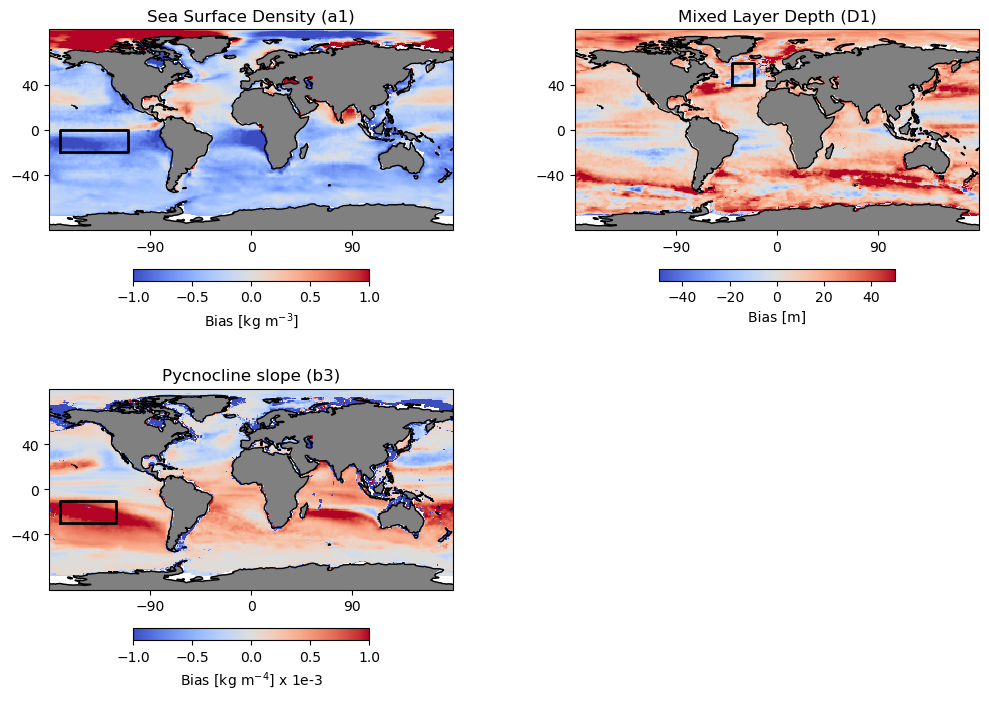

In [163]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.4)
projection = ccrs.PlateCarree(central_longitude=0)

titles = ["Sea Surface Density (a1)", "Mixed Layer Depth (D1)", "Pycnocline slope (b3)"]
units = ["[kg m$^{-3}$]", "[m]", "[kg m$^{-4}$] x 1e-3"]

vmins = [-1, -50, -1]
vmaxs = [1, 50, 1]

lat_region_NA = [40, 60]
lon_region_NA = [320, 340]

lat_region_EPA = [-20, 0]
lon_region_EPA = [190, 250]

lat_region_SPA = [-30, -10]
lon_region_SPA = [190, 240]

lat_region_SOPA = [-60, -50]
lon_region_SOPA = [200, 300]


# Loop through the subplots
for i in range(3):
    ax = fig.add_subplot(gs[i // 2, i % 2], projection=projection)
    ax.set_title(titles[i])
    datai, loni = add_cyclic_point(data[i], coord=lon)
    # Plot the data
    img = ax.pcolormesh(loni, lat, datai, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmins[i], vmax=vmaxs[i])
    
    if i==0:
        lon_min=lon_region_EPA[0]
        lon_max=lon_region_EPA[1]
        lat_min=lat_region_EPA[0]
        lat_max=lat_region_EPA[1]
        
        ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
            [lat_min, lat_min, lat_max, lat_max, lat_min],
            color='k', linewidth=2, transform=ccrs.PlateCarree(), zorder=4)
    elif i==1:
        
        lon_min=lon_region_NA[0]
        lon_max=lon_region_NA[1]
        lat_min=lat_region_NA[0]
        lat_max=lat_region_NA[1]
        
        ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
            [lat_min, lat_min, lat_max, lat_max, lat_min],
            color='k', linewidth=2, transform=ccrs.PlateCarree(), zorder=4)
    elif i==2:
        
        lon_min=lon_region_SPA[0]
        lon_max=lon_region_SPA[1]
        lat_min=lat_region_SPA[0]
        lat_max=lat_region_SPA[1]
        
        ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
            [lat_min, lat_min, lat_max, lat_max, lat_min],
            color='k', linewidth=2, transform=ccrs.PlateCarree(), zorder=4)       
    
    # Add land and coastlines
    ax.add_feature(cfeature.LAND, color="gray")
    ax.coastlines()
    ax.set_xticks([0, 90, 270], crs=ccrs.PlateCarree())  # Fixed longitude ticks
    ax.set_yticks([-40, 0, 40], crs=ccrs.PlateCarree())  # Fixed latitude ticks
    

    # Add colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="horizontal", fraction=0.046, pad=0.15)
    cbar.ax.set_xlabel(f"Bias {units[i]}")
    
        # Zonal Mean Bias (Stick to the Right of Each Map)
    '''
    ax_zonal = ax.inset_axes([1.02, 0, 0.2, 1], transform=ax.transAxes)  # Small inset plot
    ax_zonal.plot(zonal_means[i], lat, color="black", lw=2)
    ax_zonal.axvline(0, color="gray", linestyle="--", lw=1)  # Zero bias line

    #ax_zonal.set_xlabel(units[i])
    ax_zonal.set_yticks([])  # Remove y-ticks to avoid duplication
    ax_zonal.set_frame_on(False)  # Remove borders for cleaner look
    ax_zonal.grid(True, linestyle="--", alpha=0.6)
    
    if i==2:
        import matplotlib.ticker as mticker
        #ax_zonal.set_xticks([-1e-3,0,1e-3])
        #ax_zonal.xaxis.set_ticklabels(['-1e-3','0','1e-3'])
        ax_zonal.set_xlim(-1,1)
        
       ''' 
        #ax_zonal.ticklabel_format(style='sci', axis='x')
    
# Show the figure
plt.show()

In [164]:
fig.savefig("/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/figures_AEC/bias_maps_boxes2.png",dpi=300)


In [135]:
lat_region = [40, 60]
lon_region = [320, 340]

cmip6_D1 = cmip6_shdr_ens_all.sel(param="D1").sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_D1=obs_shdr_clim.sel(param="D1").sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_Ft=cmip6_ssdflux_ens_all.Ft.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_Ft=obs_ssdflux_clim.Ft.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_Fs=cmip6_ssdflux_ens_all.Fs.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_Fs=obs_ssdflux_clim.Fs.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_curl=cmip6_curl_ens_all.curl.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_curl=obs_curl_clim.curl.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_wsm=cmip6_wsm_ens_all.wsm.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_wsm=obs_wsm_clim.wsm.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

#D1_seasonal_cycle = D1.median(dim="model")
D1_seasonal_cycle = cmip6_D1["shdr"].median(dim="model")
D1_spread = cmip6_D1["shdr"].std(dim="model")


D_bias=(cmip6_D1-obs_D1).mean('month').shdr.values
Ft_bias=(cmip6_Ft-obs_Ft).mean('month').values


Fs_bias=(cmip6_Fs-obs_Fs).mean('month').values
curl_bias=(cmip6_curl-obs_curl).mean('month').values
wsm_bias=(cmip6_wsm-obs_wsm).mean('month').values

all_bias=[Ft_bias,Fs_bias,curl_bias,wsm_bias]


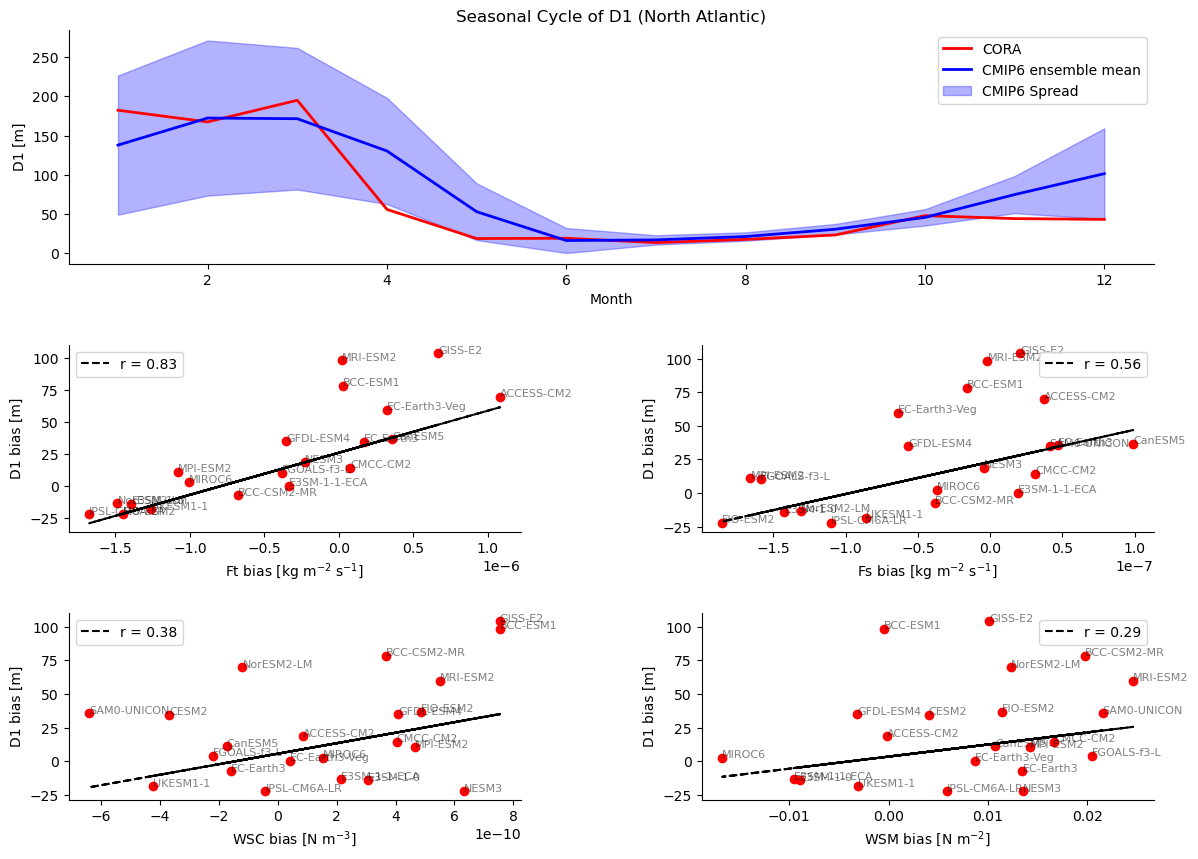

In [136]:
import scipy.stats as stats
from scipy.stats import theilslopes
from sklearn.linear_model import HuberRegressor
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))

gs = gridspec.GridSpec(3, 2, height_ratios=[2.5, 2, 2], hspace=0.4, wspace=0.4)

# Subplot 1: Seasonal Cycle of D1
ax1 = fig.add_subplot(gs[0, :])
months = range(1, 13)
ax1.plot(months, obs_D1.shdr, color="red", linewidth=2,label="CORA")
ax1.plot(months, D1_seasonal_cycle, color="blue", linewidth=2, label="CMIP6 ensemble mean")
ax1.fill_between(months, D1_seasonal_cycle - D1_spread, D1_seasonal_cycle + D1_spread, color="blue", alpha=0.3, label="CMIP6 Spread")
ax1.set_title("Seasonal Cycle of D1 (North Atlantic)")
ax1.set_xlabel("Month")
ax1.set_ylabel("D1 [m]")
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

titles = ["Thermal Contribution Ft", "Salinity Contribution Fs", "Wind Stress Curl", "Wind Stress Magnitude"]
units = [ "Ft bias [kg m$^{-2}$ s$^{-1}$]", "Fs bias [kg m$^{-2}$ s$^{-1}$]","WSC bias [N m$^{-3}$]", "WSM bias [N m$^{-2}$]"]
model_names=cmip6_D1.model.values
for i in range(len(all_bias)):
    i_bias=all_bias[i]
    mask = ~np.isnan(D_bias) & ~np.isnan(i_bias)  # Only keep valid values
    D_bias_clean = D_bias[mask]
    i_bias_clean = i_bias[mask]

    q1 = np.percentile(i_bias_clean, 25)
    q3 = np.percentile(i_bias_clean, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Apply IQR filter to remove outliers
    outlier_mask = (i_bias_clean >= lower_bound) & (i_bias_clean <= upper_bound)
    D_bias_filtered = D_bias_clean[outlier_mask]
    i_bias_filtered = i_bias_clean[outlier_mask]

    slope, intercept, r_value, p_value, std_err = stats.linregress(i_bias_filtered, D_bias_filtered)

    slope, intercept, lower, upper = theilslopes(D_bias_clean, i_bias_clean, 0.95)

    # Compute Pearson correlation coefficient separately
    r_value, p_value = pearsonr(D_bias_filtered, i_bias_filtered)


    # Subplot 2: Regression Analysis
    ax2 = fig.add_subplot(gs[2+i])
    ax2.scatter(i_bias_filtered, D_bias_filtered, color="red")
    for x, t, c in zip(i_bias_filtered, D_bias_filtered, model_names_clean):
        ax2.text(x, t, c, color='k',alpha=0.5, fontsize=8)#, label=f"r = {r_value:.2f}")
    ax2.plot(i_bias_filtered, slope * i_bias_filtered + intercept, color="black", linestyle="--", label=f"r = {r_value:.2f}")
    #ax2.set_title(titles[i])
    ax2.set_xlabel(units[i])
    ax2.set_ylabel("D1 bias [m]")
    ax2.legend()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    #ax2.set_xlim(-2e-6,2e-6)

# Adjust Layout and Show the Figure
#plt.tight_layout()

#fig.savefig("/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/figures_AEC/PBIAS_NA.png",dpi=300)

plt.show()
fig.savefig("/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/figures_AEC/D1_NA.png",dpi=300)


In [103]:
obs_D1

<xarray.Dataset>
Dimensions:  (month: 12, lev: 112)
Coordinates:
  * lev      (lev) float32 1.0 3.0 5.0 10.0 ... 1.16e+03 1.18e+03 1.2e+03
    param    <U2 'D1'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    shdr     (month) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [140]:
lat_region = [-20, 0]
lon_region = [190, 250]



#lat_region = [-30, -10]
#lon_region = [200, 300]

cmip6_D1 = cmip6_shdr_ens_all.sel(param="a1").sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_D1=obs_shdr_clim.sel(param="a1").sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

#lat_region = [-60, -50]
#lon_region = [200, 260]

cmip6_Ft=cmip6_ssdflux_ens_all.Ft.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_Ft=obs_ssdflux_clim.Ft.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

#cmip6_Ft = cmip6_shdr_ens_all.sel(param="a1").shdr.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
#obs_Ft=obs_shdr_clim.sel(param="a1").shdr.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))


cmip6_Fs=cmip6_ssdflux_ens_all.Fs.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_Fs=obs_ssdflux_clim.Fs.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_curl=cmip6_curl_ens_all.curl.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_curl=obs_curl_clim.curl.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_wsm=cmip6_wsm_ens_all.wsm.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_wsm=obs_wsm_clim.wsm.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

#D1_seasonal_cycle = D1.median(dim="model")
D1_seasonal_cycle = cmip6_D1["shdr"].median(dim="model")
D1_spread = cmip6_D1["shdr"].std(dim="model")

D_bias=(cmip6_D1-obs_D1).mean('month').shdr.values
Ft_bias=(cmip6_Ft-obs_Ft).mean('month').values


Fs_bias=(cmip6_Fs-obs_Fs).mean('month').values
curl_bias=(cmip6_curl-obs_curl).mean('month').values
wsm_bias=(cmip6_wsm-obs_wsm).mean('month').values

all_bias=[Ft_bias,Fs_bias,curl_bias,wsm_bias*1e3]

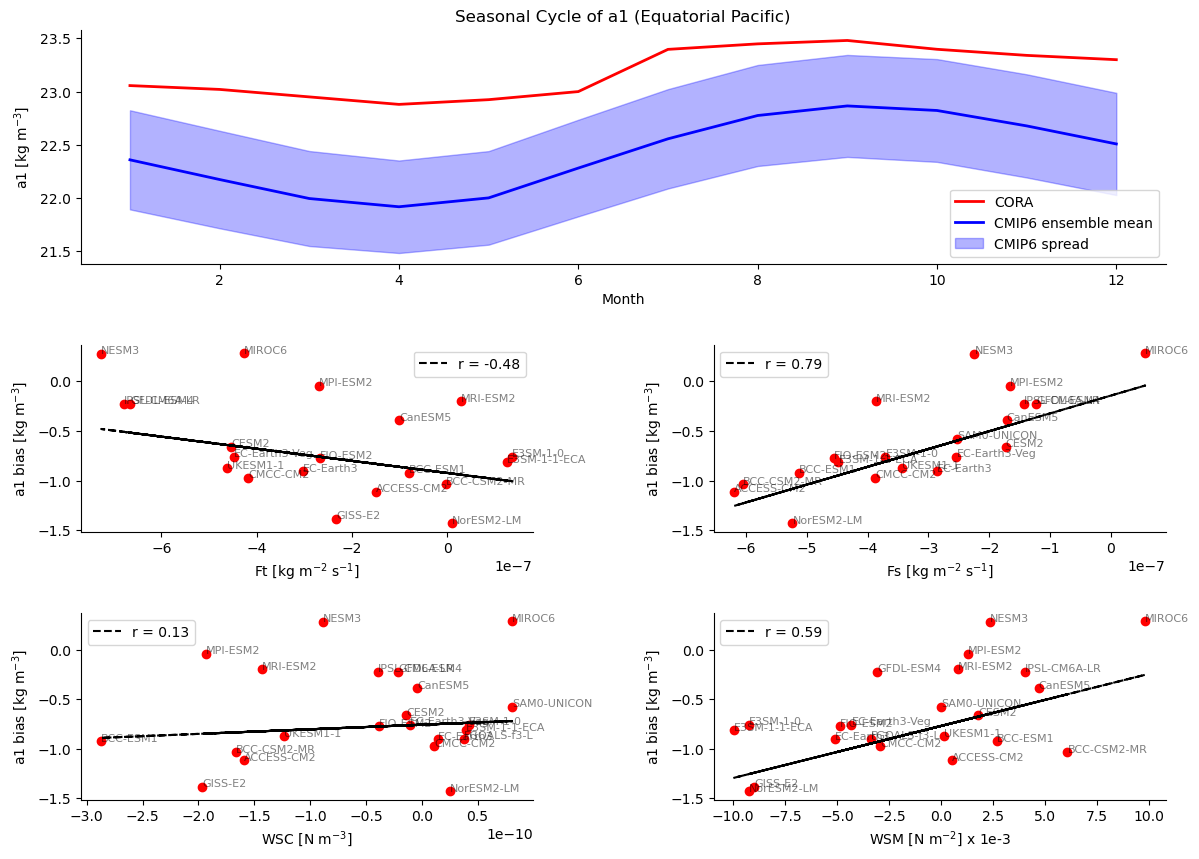

In [142]:
import scipy.stats as stats
from scipy.stats import theilslopes
from sklearn.linear_model import HuberRegressor
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))

gs = gridspec.GridSpec(3, 2, height_ratios=[2.5, 2, 2], hspace=0.4, wspace=0.4)

# Subplot 1: Seasonal Cycle of D1
ax1 = fig.add_subplot(gs[0, :])
months = range(1, 13)
ax1.plot(months, obs_D1.shdr, color="red", linewidth=2,label="CORA")
ax1.plot(months, D1_seasonal_cycle, color="blue", linewidth=2, label="CMIP6 ensemble mean")
ax1.fill_between(months, D1_seasonal_cycle - D1_spread, D1_seasonal_cycle + D1_spread, color="blue", alpha=0.3, label="CMIP6 spread")
ax1.set_title("Seasonal Cycle of a1 (Equatorial Pacific)")
ax1.set_xlabel("Month")
ax1.set_ylabel("a1 [kg m$^{-3}$]")
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

titles = ["Ft", "Fs", "Wind Stress Curl", "Wind Stress Magnitude"]
units = [ "Ft [kg m$^{-2}$ s$^{-1}$]", "Fs [kg m$^{-2}$ s$^{-1}$]","WSC [N m$^{-3}$]", "WSM [N m$^{-2}$] x 1e-3"]
model_names=cmip6_D1.model.values
for i in range(len(all_bias)):
    i_bias=all_bias[i]
    mask = ~np.isnan(D_bias) & ~np.isnan(i_bias)  # Only keep valid values
    D_bias_clean = D_bias[mask]
    i_bias_clean = i_bias[mask]
    model_names_clean=model_names[mask]

    q1 = np.percentile(i_bias_clean, 25)
    q3 = np.percentile(i_bias_clean, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Apply IQR filter to remove outliers
    outlier_mask = (i_bias_clean >= lower_bound) & (i_bias_clean <= upper_bound)
    D_bias_filtered = D_bias_clean[outlier_mask]
    i_bias_filtered = i_bias_clean[outlier_mask]
    model_names_clean=model_names_clean[outlier_mask]
    
    q1 = np.percentile(D_bias_filtered, 25)
    q3 = np.percentile(D_bias_filtered, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outlier_mask = (D_bias_filtered >= lower_bound) & (D_bias_filtered <= upper_bound)
    D_bias_filtered = D_bias_filtered[outlier_mask]
    i_bias_filtered = i_bias_filtered[outlier_mask]
    model_names_clean=model_names_clean[outlier_mask]
    
    

    slope, intercept, r_value, p_value, std_err = stats.linregress(i_bias_filtered, D_bias_filtered)

    slope, intercept, lower, upper = theilslopes(D_bias_clean, i_bias_clean, 0.95)

    # Compute Pearson correlation coefficient separately
    r_value, p_value = pearsonr(D_bias_filtered, i_bias_filtered)


    # Subplot 2: Regression Analysis
    ax2 = fig.add_subplot(gs[2+i])
    ax2.scatter(i_bias_filtered, D_bias_filtered, color="red")#, label=f"r = {r_value:.2f}")
    for x, t, c in zip(i_bias_filtered, D_bias_filtered, model_names_clean):
        ax2.text(x, t, c, color='k',alpha=0.5, fontsize=8)
    
    ax2.plot(i_bias_filtered, slope * i_bias_filtered + intercept, color="black", linestyle="--", label=f"r = {r_value:.2f}")
    #ax2.set_title(titles[i])
    ax2.set_xlabel(units[i])
    ax2.set_ylabel("a1 bias [kg m$^{-3}$]")
    ax2.legend()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    #ax2.set_xlim(-2e-6,2e-6)

# Adjust Layout and Show the Figure
#plt.tight_layout()
plt.show()

fig.savefig("/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/figures_AEC/a1_EqPA.png",dpi=300)


In [167]:
lat_region = [-20, 0]
lon_region = [190, 250]

lat_region = [-30, -10]
lon_region = [190, 240]


#lat_region = [-30, -10]
#lon_region = [200, 300]

cmip6_D1 = cmip6_shdr_ens_all.sel(param="b3").sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_D1=obs_shdr_clim.sel(param="b3").sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

lat_region = [-60, -50]
lon_region = [200, 260]

cmip6_Ft=cmip6_ssdflux_ens_all.Ft.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_Ft=obs_ssdflux_clim.Ft.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_Ft = cmip6_shdr_ens_all.sel(param="a1").shdr.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_Ft=obs_shdr_clim.sel(param="a1").shdr.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))


cmip6_Fs=cmip6_ssdflux_ens_all.Fs.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_Fs=obs_ssdflux_clim.Fs.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_curl=cmip6_curl_ens_all.curl.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_curl=obs_curl_clim.curl.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

cmip6_wsm=cmip6_wsm_ens_all.wsm.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))
obs_wsm=obs_wsm_clim.wsm.sel(lon=slice(lon_region[0],lon_region[1]),lat=slice(lat_region[0],lat_region[1])).mean(('lat','lon'))

#D1_seasonal_cycle = D1.median(dim="model")
D1_seasonal_cycle = cmip6_D1["shdr"].median(dim="model")
D1_spread = cmip6_D1["shdr"].std(dim="model")

D_bias=(cmip6_D1-obs_D1).mean('month').shdr.values
Ft_bias=(cmip6_Ft-obs_Ft).mean('month').values


Fs_bias=(cmip6_Fs-obs_Fs).mean('month').values
curl_bias=(cmip6_curl-obs_curl).mean('month').values
wsm_bias=(cmip6_wsm-obs_wsm).mean('month').values

all_bias=[Ft_bias,Fs_bias,curl_bias,wsm_bias]

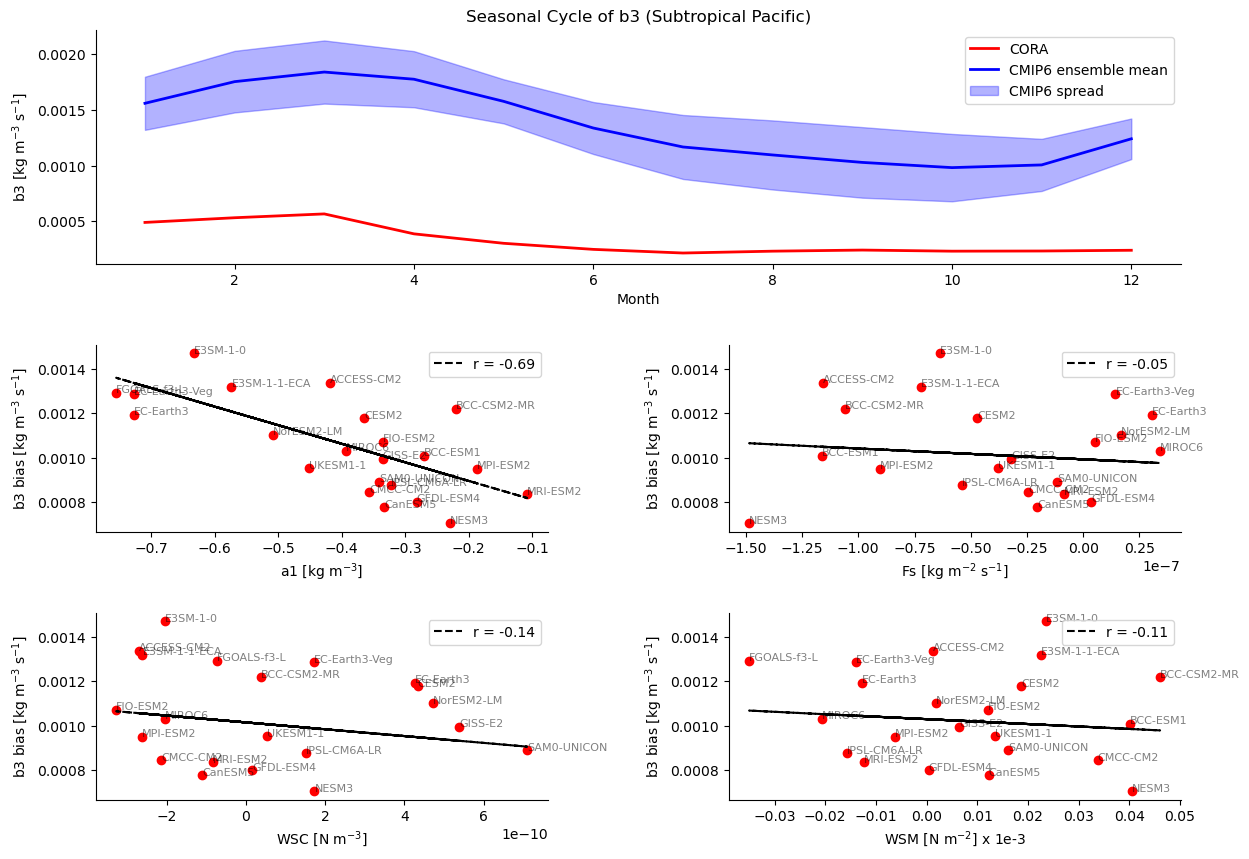

In [169]:
import scipy.stats as stats
from scipy.stats import theilslopes
from sklearn.linear_model import HuberRegressor
from scipy.stats import pearsonr
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))

gs = gridspec.GridSpec(3, 2, height_ratios=[2.5, 2, 2], hspace=0.4, wspace=0.4)

# Subplot 1: Seasonal Cycle of D1
ax1 = fig.add_subplot(gs[0, :])
months = range(1, 13)
ax1.plot(months, obs_D1.shdr, color="red", linewidth=2,label="CORA")
ax1.plot(months, D1_seasonal_cycle, color="blue", linewidth=2, label="CMIP6 ensemble mean")
ax1.fill_between(months, D1_seasonal_cycle - D1_spread, D1_seasonal_cycle + D1_spread, color="blue", alpha=0.3, label="CMIP6 spread")
ax1.set_title("Seasonal Cycle of b3 (Subtropical Pacific)")
ax1.set_xlabel("Month")
ax1.set_ylabel("b3 [kg m$^{-3}$ s$^{-1}$]")
ax1.legend()
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

titles = ["a1", "Fs", "Wind Stress Curl", "Wind Stress Magnitude"]
units = [ "a1 [kg m$^{-3}$]", "Fs [kg m$^{-2}$ s$^{-1}$]","WSC [N m$^{-3}$]", "WSM [N m$^{-2}$] x 1e-3"]
model_names=cmip6_D1.model.values
for i in range(len(all_bias)):
    i_bias=all_bias[i]
    mask = ~np.isnan(D_bias) & ~np.isnan(i_bias)  # Only keep valid values
    D_bias_clean = D_bias[mask]
    i_bias_clean = i_bias[mask]
    model_names_clean=model_names[mask]

    q1 = np.percentile(i_bias_clean, 25)
    q3 = np.percentile(i_bias_clean, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Apply IQR filter to remove outliers
    outlier_mask = (i_bias_clean >= lower_bound) & (i_bias_clean <= upper_bound)
    D_bias_filtered = D_bias_clean[outlier_mask]
    i_bias_filtered = i_bias_clean[outlier_mask]
    model_names_clean=model_names_clean[outlier_mask]
    
    q1 = np.percentile(D_bias_filtered, 25)
    q3 = np.percentile(D_bias_filtered, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outlier_mask = (D_bias_filtered >= lower_bound) & (D_bias_filtered <= upper_bound)
    D_bias_filtered = D_bias_filtered[outlier_mask]
    i_bias_filtered = i_bias_filtered[outlier_mask]
    model_names_clean=model_names_clean[outlier_mask]
    
    

    slope, intercept, r_value, p_value, std_err = stats.linregress(i_bias_filtered, D_bias_filtered)

    slope, intercept, lower, upper = theilslopes(D_bias_clean, i_bias_clean, 0.95)

    # Compute Pearson correlation coefficient separately
    r_value, p_value = pearsonr(D_bias_filtered, i_bias_filtered)


    # Subplot 2: Regression Analysis
    ax2 = fig.add_subplot(gs[2+i])
    ax2.scatter(i_bias_filtered, D_bias_filtered, color="red")#, label=f"r = {r_value:.2f}")
    for x, t, c in zip(i_bias_filtered, D_bias_filtered, model_names_clean):
        ax2.text(x, t, c, color='k',alpha=0.5, fontsize=8)
    
    ax2.plot(i_bias_filtered, slope * i_bias_filtered + intercept, color="black", linestyle="--", label=f"r = {r_value:.2f}")
    #ax2.set_title(titles[i])
    ax2.set_xlabel(units[i])
    ax2.set_ylabel("b3 bias [kg m$^{-3}$ s$^{-1}$]")
    ax2.legend()
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    #ax2.set_xlim(-2e-6,2e-6)

# Adjust Layout and Show the Figure
#plt.tight_layout()
plt.show()

fig.savefig("/Users/ignasi/Desktop/Oceanography/IEO/projects/stratification_CMIP6/figures_AEC/b3_STPA_SO_a1.png",dpi=300)
